In [1]:
using DiffEqFlux,OrdinaryDiffEq,Flux,Optim,Plots,DifferentialEquations,CSV,DataFrames
using ForwardDiff

In [2]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix{Float32}(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix{Float32}(data0[1:354,[4]])))
    dataset2020=Array(transpose(Matrix{Float32}(data1[1:365,[4]])))
    end

1×365 Matrix{Float32}:
 10.2  11.3  12.0  12.2  10.2  12.2  …  14.0  11.8  12.7  13.5  13.1  12.3

In [ ]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022-1.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix{Float32}(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix{Float32}(data0[1:365,[5]])))
    dataset2020=Array(transpose(Matrix{Float32}(data1[1:365,[4]])))
    x0=Array(transpose(dataset2020[1:364]))
    y0=Array(transpose(dataset2020[2:365]))
    x1=Array(transpose(dataset2021[1:364]))
    y1=Array(transpose(dataset2021[2:365]))
    x2=Array(transpose(dataset2022[1:364]))
    y2=Array(transpose(dataset2022[2:365]))
end

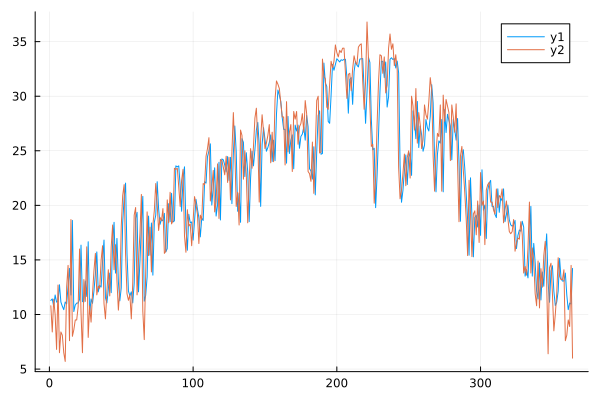

In [3]:
begin
    model=Chain(GRU(1 => 10), Dense(10 => 1))
    function loss(x)
        l=sum(abs2,(model(x)[1:364].-x[2:365]))
    end
    opt=Adam(Float32(0.01))
    for i in 1:2000
        Flux.train!(loss,Flux.params(model) , [dataset2021,dataset2021], opt)
    end
    plot(transpose(model(dataset2021))[1:364])
    plot!(transpose(dataset2021)[2:365])
end

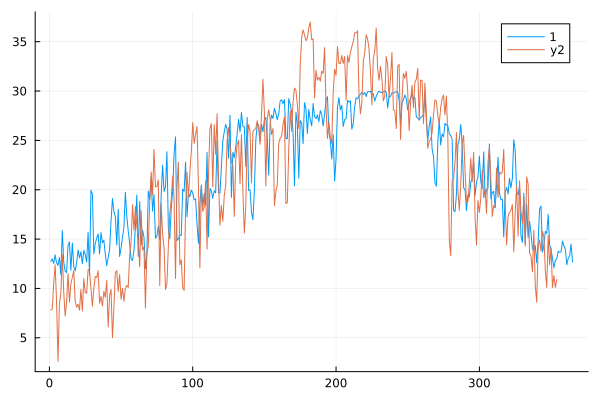

In [4]:
begin
    x1=dataset2020
    y1=dataset2021
    model=Chain(GRU(1 => 10), Dense(10 => 1))
    function loss(x,y)
        l=sum(abs2,model(x).-y)
    end
    opt=Adam(0.01)
    for i =1:3000
      grad = gradient(()->loss(x1, y1), Flux.params(model))
      Flux.update!(opt, Flux.params(model), grad)
    end
    plot(transpose(model(dataset2021)),label=1)
    plot!(transpose(dataset2022))
end

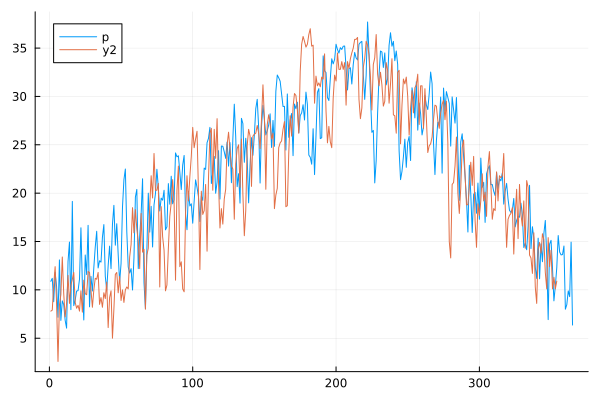

In [5]:
tspan=(Float32(0.0),Float32(1.0))
prob_neuralode = NeuralODE(model, tspan, saveat = 0.03)
prob=prob_neuralode(dataset2021)
plot(transpose(prob[2]),label='p')
plot!(transpose(dataset2022))

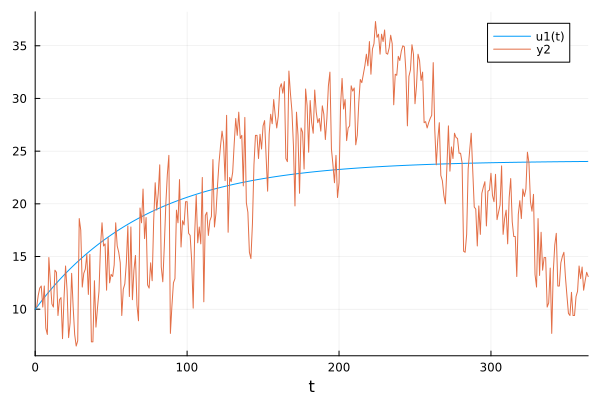

In [31]:
begin
    dudt2=Chain(GRU(1 => 10), Dense(10 => 1))
    tspan = (Float32(0.0),Float32(364))
    p,re = Flux.destructure(dudt2) # use this p as the initial condition!
    dudt(u,p,t) = re(p)(u) # need to restrcture for backprop!
    u0=[dataset2020[1]]
    prob = ODEProblem(dudt,u0,tspan)
    function loss(x)
        pred=Array(solve(prob,Tsit5(),u0=u0,p=p,saveat=1))
        l=sum(abs2,(pred[2:365].-x[2:365]))/length(364)
    end
    for i =1:1000
        grad = gradient(()->loss(dataset2020), Flux.params(u0,p))
        Flux.update!(opt, Flux.params(u0,p), grad)
      end
    sol1=solve(prob,Tsit5(),u0=u0,p=Flux.params(u0,p)[2],saveat=1)
    plot(sol1)
    plot!(transpose(dataset2020))
end